---
title: "Few-shot Sentiment Analysis with ChatGPT"
description: "Can we use OpenAI's ChatGPT to predict the sentiment of tweets?"
date: "2023-03-12"
image: "image.png"
format:
  html:
    code-fold: show
    code-line-numbers: false
jupyter: python3
---

After we took a quick look at the ChatGPT API and some example use cases in the last post, let's dive a little bit deeper and see how we can use ChatGPT for zero-shot sentiment analysis. 

In [3]:
#| code-fold: true
import openai
import tiktoken
import getpass
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from datasets import load_dataset
from functools import partial

In [4]:
#| code-fold: true
rng = np.random.default_rng(1)

In [5]:
#| code-fold: show
api_key = getpass.getpass("Enter the OpenAI API Key:")
openai.api_key = api_key

Enter the OpenAI API Key:··········


## The Data

As our example we'll use the `emotion` dataset that is available from the HuggingFace hub:

In [6]:
#| output: false
ds = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

The dataset contains tweets which have been labelled with one of six emotions: anger, disgust, fear, joy, sadness, and surprise.

In [7]:
#| code-fold: true
label_int2str = {i: ds["train"].features["label"].int2str(i) for i in range(6)}
label_str2int = {v: k for k, v in label_int2str.items()}
ds.set_format(type="pandas")
df = ds["train"][:]
df["label_str"] = df["label"].map(label_int2str)
df

,text,label,label_str
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


Let's have a look at one full example per emotion:

In [8]:
for emotion, ex in df.groupby("label_str")["text"].agg("first").items():
    print(f"{emotion}: {ex}")

anger: im grabbing a minute to post i feel greedy wrong
fear: i feel as confused about life as a teenager or as jaded as a year old man
joy: i have been with petronas for years i feel that petronas has performed well and made a huge profit
love: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
sadness: i didnt feel humiliated
surprise: ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny


As it turns out, the labels are not always entirely obvious. In a real-world dataset that has been labeled by human annotators this is to be expected, of course, but it will make things hard for a few-shot classifier. 

Note that we are also dealing with class imbalance. For example, tweets that express joy are ten times more common in the dataset than tweets expressing surprise.

In [9]:
df["label_str"].value_counts()/len(df)

joy         0.335125
sadness     0.291625
anger       0.134937
fear        0.121063
love        0.081500
surprise    0.035750
Name: label_str, dtype: float64

## Prompting ChatGPT

We can tweak multiple parameters to prime ChatGPT for our use case; the most important one unquestionably being the system prompt. Let's try the following:

In [10]:
system_prompt = """You are a helpful assistant. Your task is sentiment analysis. 
Classify the sentiment of the user's text with ONLY ONE of the following emotions:
- joy
- love
- fear
- anger
- sadness
- surprise

After classifying a text, always end your reply with ".".
"""

To ensure that ChatGPT only replies with one of the given emotions, we can modify the likelihood of specific tokens appearing in the model's answer using the API's `logit_bias` parameter. As per the [API reference](https://platform.openai.com/docs/api-reference/chat), we can map token IDs to bias values ranging from -100 to 100 (where -100 results in the ban of a given token and 100 leads to its exclusive selection). The bias values will be added to the logits generated by the model prior to sampling.

Let's create a dictionary of biases for our purpose. We'll use OpenAI's `tiktoken` package to encode the emotions in our list. Since `tiktoken` is a subword tokenizer, one emotion can map to multiple token IDs:

In [11]:
encoder = tiktoken.encoding_for_model("gpt-3.5-turbo")

for emotion in ["joy", "love", "fear", "anger", "sadness", "surprise"]:
    print(f"{emotion}: {encoder.encode(emotion)}")

print(f"\nend token: {encoder.encode('.')}")

joy: [4215]
love: [31153]
fear: [69, 686]
anger: [4091]
sadness: [83214, 2136]
surprise: [20370, 9868]

end token: [13]


In [12]:
def create_biases(tokens, bias_value):
    biases = {}
    for token in tokens:
        token_ids = encoder.encode(token)
        for token_id in token_ids:
            biases[token_id] = bias_value
    return biases

Let's try a bias value of `10` for each token ID. This is of course just a guess; another setting may work better. To ensure that the model always picks the token with the highest logit, we'll set the `temperature` to `0.0`.

Finally, we can use the `max_tokens` parameter as well as the `stop` parameter to further constrain the model:

- We set `max_tokens` to `3` meaning that ChatGPT will never reply with more tokens.
- We set `stop` to `"."` so that the model never generates any more tokens after replying with `"."`.

Since we want to do few-shot sentiment analysis, we'll provide five examples per category to the model. To do this, we'll provide the tweet using the `user` role and the correct answer using the `assistant` role that is available in the API.

In [13]:
train_examples = df.groupby("label_str")[["text", "label_str"]].sample(5, random_state=1).reset_index(drop=True)
train_examples = train_examples.iloc[rng.permuted(np.arange(train_examples.shape[0]))]
train_examples = dict(zip(train_examples.text, train_examples.label_str))

fewshot = []
for tweet, emotion in train_examples.items():
    fewshot.append({"role": "user", "content": tweet})
    fewshot.append({"role": "assistant", "content": emotion + "."})
fewshot[:4]

[{'role': 'user',
  'content': 'i always feel awkward when im alone in a crowd of peers and feel the need to make friends'},
 {'role': 'assistant', 'content': 'sadness.'},
 {'role': 'user',
  'content': 'i have a feeling i took so much time but kuya buddy and kuya angee have been very supportive all the way'},
 {'role': 'assistant', 'content': 'love.'}]

Finally, we'll wrap the entire thing in a simple function:

In [29]:
def get_sentiment(example, system_prompt, fewshot_examples, emotions, end_token, bias_value=10):
    biases = create_biases(emotions + [end_token], bias_value)
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            *fewshot_examples,
            {"role": "user", "content": example}
        ],
        temperature=0.0,
        max_tokens=3,
        stop=end_token,
        logit_bias=biases
    )
    sentiment = completion["choices"][0]["message"]["content"]
    return sentiment

Now let's try this for the first tweet in the category "joy" that we've seen earlier:

In [19]:
get_sentiment(example="i have been with petronas for years i feel that petronas has performed well and made a huge profit",
              system_prompt=system_prompt,
              fewshot_examples=fewshot,
              emotions=list(df["label_str"].unique()),
              end_token=".")

'joy'

This actually works! But how well? To find out we'll use a random subset of 100 rows from the dataset's predefined test set:

In [59]:
test_df = ds["test"][:]
test_df["label_str"] = test_df["label"].map(label_int2str)
test_df = test_df.sample(n=100, random_state=1)

In [60]:
get_chatgpt_pred = partial(get_sentiment, system_prompt=system_prompt, fewshot_examples=fewshot, emotions=list(df["label_str"].unique()), end_token=".")

In [61]:
test_df["chatgpt_pred_str"] = test_df["text"].apply(get_chatgpt_pred)

In [64]:
test_df.head(20)

,text,label,label_str,chatgpt_pred_str
674,i want to feel assured that my life will be go...,1,joy,joy
1699,i hear someone say we should just let gardener...,3,anger,anger
1282,im always feeling so agitated overly excited a...,3,anger,anger
1315,i guess it comes from believing that when i wa...,1,joy,sadness
1210,i feel like this beats out just about any popu...,1,joy,joy
1636,i feel like we re getting a terrific recruiter...,1,joy,joy
613,i feel curious because i would like to explore...,5,surprise,surprise
447,i did not know this i could not look out upon ...,0,sadness,sadness
1131,i feel terrible when i hurt peoples feelings w...,0,sadness,sadness
808,i can t say for certain why but it actually ma...,1,joy,surprise


As we can see in the confusion matrix, the results are mixed. Given the few-shot setting and the sometimes debatable labels, ChatGPT probably still performed quite well. After all, it can be quite hard to draw a distinction between classes like joy and love or anger and fear. Nonetheless, finetuning a dedicated model for this task (e.g., a small model of the DeBERTa family) would have yielded much better results.

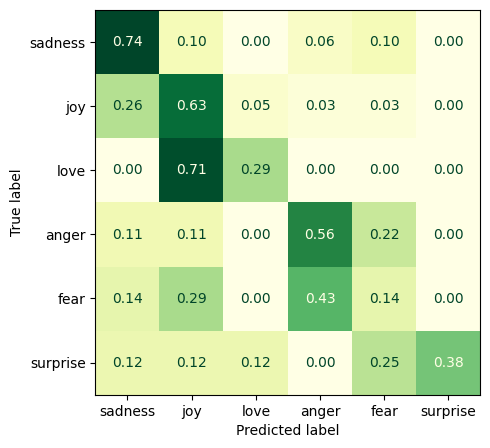

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(test_df.chatgpt_pred_str.map(label_str2int), test_df.label_str.map(label_str2int), normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_int2str.values())
disp.plot(cmap="YlGn", values_format=".2f", ax=ax, colorbar=False);